In [1]:
%matplotlib inline

import pickle
from sklearn.metrics import roc_auc_score as ras
from sklearn.metrics import roc_curve as rc
from scipy.optimize import curve_fit as cf
import scipy.ndimage as snd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from train_cnn import create_tf_graph
from mcmc_lumpy import *
from lumpybg import *

# import training data and define signal difference between the 2 classes
_, _, _, _, tmax, tmin = data_import('dataset20.mat',48000)
obj_dim1 = [28, 33] # Define signal position dim1
obj_dim2 = [29, 32] # Define signal position dim2
signal_intensity = 0.1
gaussian_sigma = 2
image_size = 64
signal = np.zeros((image_size, image_size))
signal[obj_dim1[0]:obj_dim1[1], obj_dim2[0]:obj_dim2[1]] = signal_intensity
signal[obj_dim2[0]:obj_dim2[1], obj_dim1[0]:obj_dim1[1]] = signal_intensity
signal = snd.filters.gaussian_filter(signal, gaussian_sigma)

In [3]:
# load mcmc results
with open('ratios4.pkl','rb') as f:
    lr, phi_set = pickle.load(f)
num_images = 200
    
# Get the images for each of the phi sets
g = []
backgrounds = np.zeros((64,64,2*num_images))
for i,phi in enumerate(phi_set):
    g.append(phi.grab_g().ravel())
    theta = phi.grab_chain(real=False)[0]
    b, _, _ = create_lumpy_background(pos=theta)
    backgrounds[:,:,i] = b

In [4]:
# Calculate covariance matrix
N_inv = np.eye(64**2)*(1/0.01)
W = backgrounds - np.repeat(np.mean(backgrounds, axis=2)[:, :, np.newaxis], num_images*2, axis=2)
W = np.reshape(W, (64**2, -1))
NsNs = np.linalg.inv(np.eye(2*num_images)+np.matmul(W.transpose(), np.matmul(N_inv, W)))
K_inv = N_inv - np.matmul(N_inv, np.matmul(W, np.matmul(NsNs, np.matmul(W.transpose(), N_inv))))
del N_inv
del W
del NsNs

# Calculate the HO test statistics
ho = []
for img in g:
    ho.append(np.dot(signal.ravel(), np.matmul(K_inv, img)))
del K_inv

# add CNN results
folder_name = 'saved_models_lb2'
model_number = 88280
data_array = (np.array(g).reshape(-1, 64, 64, 1) - tmin)/(tmax - tmin)
net_input, _, readout, _, _ = create_tf_graph()
sess = tf.Session()
tf.train.Saver().restore(sess, './{}/ho_cnn_model.ckpt-{}'.format(folder_name, model_number))
cnn = sess.run(readout, feed_dict={net_input: data_array})

INFO:tensorflow:Restoring parameters from ./saved_models_lb2/ho_cnn_model.ckpt-88280


AUC HO: 0.8517750000000001
AUC MCMC: 0.878025
AUC CNN: 0.8881749999999999


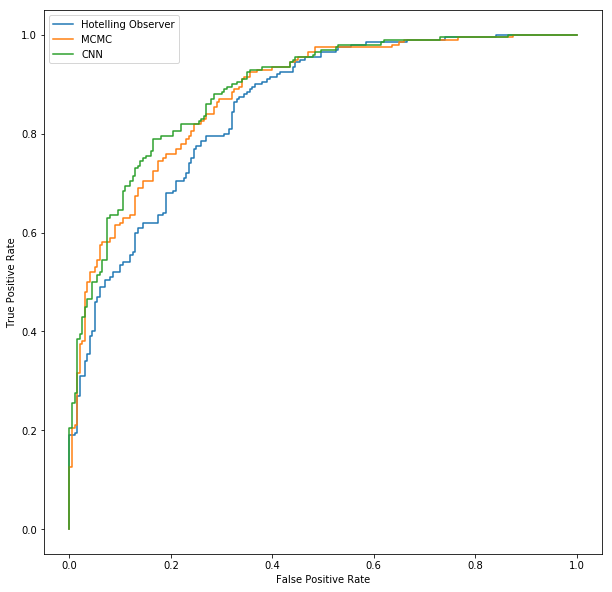

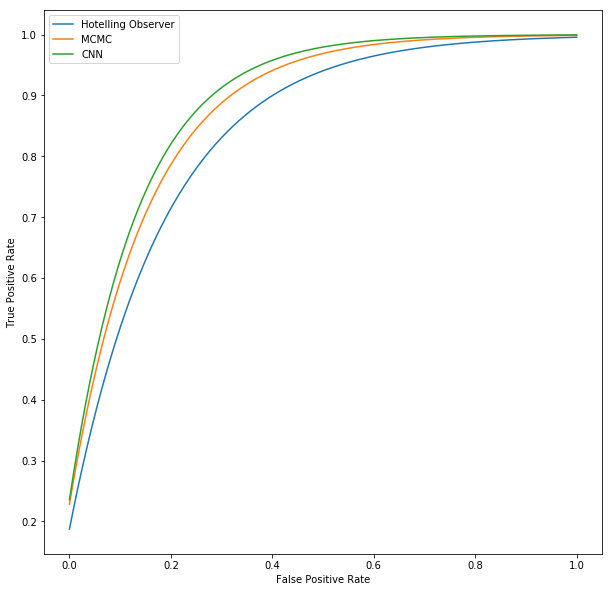

In [5]:
# Print the AUC
print('AUC HO: {}'.format(ras(num_images*[1,0],ho)))
print('AUC MCMC: {}'.format(ras(num_images*[1,0],lr)))
print('AUC CNN: {}'.format(ras(num_images*[1,0],cnn)))

# Calculate ROC curves
fpr_ho, tpr_ho, _ = rc(num_images*[1,0], ho)
fpr_mcmc, tpr_mcmc, _ = rc(num_images*[1,0], lr)
fpr_cnn, tpr_cnn, _ = rc(num_images*[1,0], cnn)

# Fit ROC curves
def func(x,a,b): return 1 - a*np.exp(b*x)
fit_ho, _ = cf(func, fpr_ho, tpr_ho)
x = np.linspace(0,1,1000)
y_ho = 1 - fit_ho[0]*np.exp(fit_ho[1]*x)
fit_mcmc, _ = cf(func, fpr_mcmc, tpr_mcmc)
y_mcmc = 1 - fit_mcmc[0]*np.exp(fit_mcmc[1]*x)
fit_cnn, _ = cf(func, fpr_cnn, tpr_cnn)
y_cnn = 1 - fit_cnn[0]*np.exp(fit_cnn[1]*x)

# plot curves
plt.figure(figsize=(10,10))
plt.plot(fpr_ho, tpr_ho, label='Hotelling Observer')
plt.plot(fpr_mcmc, tpr_mcmc, label='MCMC')
plt.plot(fpr_cnn, tpr_cnn, label='CNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.figure(figsize=(10,10))
plt.plot(x, y_ho, label='Hotelling Observer')
plt.plot(x, y_mcmc, label='MCMC')
plt.plot(x, y_cnn, label='CNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()